## Markov Switching Model from scratch

For references check:
- https://www.stat.cmu.edu/~cshalizi/dst/18/lectures/24/lecture-24.html

In [46]:
from scipy.stats import norm
# from scipy.signal import fftconvolve
import numpy as np
import matplotlib.pyplot as plt

## Test data preparation

### Simulated problem
Problem parameters
- n_states = 2
- mu_0 = -1
- std_0 = 1
- mu_1 = 1
- std_1 = 0.7
- p00 = 0.8
- p11 = 0.9

In [243]:
mu0 = -1
mu1 = 1
std0=1
std1=0.7
p00=0.8
p11=0.9

N = 100

In [244]:
x = np.zeros(N)
s = np.zeros(N)
s[0] = 0
x[0] = norm.rvs(loc=mu0,scale=std0)

In [247]:
for i in range(1,N-1):
    r = np.random.rand()
    if s[i] == 0:
        x[i] = norm.rvs(loc=mu0,scale=std0)
        if r > p00:
            s[i+1] = 1
        else:
            s[i+1] = s[i]
    else:
        x[i] = norm.rvs(loc=mu1,scale=std1)
        if r > p11:
            s[i+1] = 0
        else:
            s[i+1] = 1
if s[-1] == 0:
    x[-1] = norm.rvs(loc=mu0,scale=std0)
else:
    x[-1] = norm.rvs(loc=mu1,scale=std1)

<bound method Figure.show of <Figure size 432x288 with 2 Axes>>

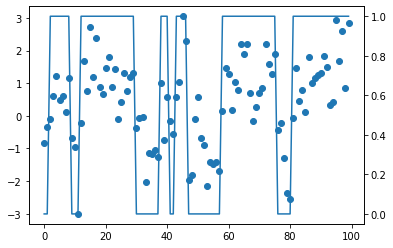

In [248]:
fig,ax = plt.subplots()
ax.scatter(np.arange(N),x)
ax2 = ax.twinx()
ax2.plot(np.arange(N),s)
fig.show

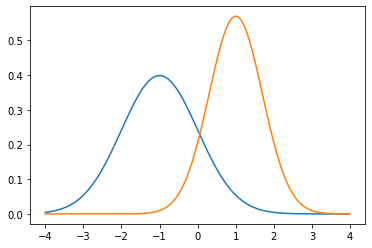

In [249]:
fig,ax = plt.subplots()
x_axis = np.arange(-4,4,0.01)
ax.plot(x_axis,norm.pdf(x_axis,loc=mu0,scale=std0))
ax.plot(x_axis,norm.pdf(x_axis,loc=mu1,scale=std1))
fig.show()

## Recursive functions

In [250]:
ss = [0,1]
mus = [-1,1]
stds = [1,0.7]
p0s=[0.6,0.4]
p00 = 0.8
p11 = 0.9
P = np.array([[p00,1-p00],[1-p11,p11]])

In [251]:
def prob_within(x,mu,std):
    return 2-2*norm.cdf(x,mu,std)

def g(x,s,mus,stds):
    return prob_within(x,mus[s],stds[s])

def p(x,mus,stds):
    return sum(g(x,s,mus,stds)*p0s[s] for s in ss)

def F0(s0,x0,mus,stds):
    return p0s[s0]*g(x0,s0,mus,stds)/p(x0,mus,stds)

def q(s0,s1,P):
    return P[s0,s1]

def F_step(s0,s1,x0,mus,stds,P):
    return sum(q(s0,s1,P)*F0(s0,x0,mus,stds) for s0 in ss)

def p_x1_x0(x0,x1,s1,mus,stds,P):
    return sum(g(x1,s,mus,stds)*F_step(s,s1,x0,mus,stds,P) for s in ss)

/home/fcelaya/quant/venv/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


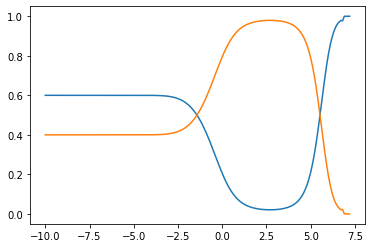

In [226]:
# Likelihood that state is certain state depending on observation value
x_axis = np.arange(-10,10,0.1)
fig,ax = plt.subplots()
ax.plot(x_axis,[F0(0,i,mus,stds) for i in x_axis])
ax.plot(x_axis,[F0(1,i,mus,stds) for i in x_axis])

## MC methods

In [252]:
np.random.seed(42)
P = np.array([[0.6,0.15,0.25],[0.2,0.7,0.1],[0.0,0.2,0.8]])
S = 3
N = 100

In [234]:
def create_chain(P,N,s0=0):
    if P.shape[0] != P.shape[1]:
        raise ValueError("Transition matrix must by of nxn size")
    else:
        S = P.shape[0]
    
    s = np.zeros(N).astype(int)
    s[0] = s0
    for i in range(1,N):
        probs = P[s[i-1]]
        r = np.random.rand()
        j = 0
        while True:
            if r < np.sum(probs[:j+1]):
                s[i] = j
                break
            else:
                j += 1
    return s

mc = create_chain(P,1000)

In [235]:
def estimate_transition_matrix(x):
    """
    Only accepts input state vector with states: 0, 1, 2, 3, etc.
    """
    n = np.unique(x).size

    P = np.array([np.zeros(n) for i in range(n)])

    for i in range(1,x.shape[0]):
        P[x[i-1],x[i]] += 1
    
    for i in range(n):
        P[i] = P[i]/np.sum(P[i])

    return P

## Recursive parameter estimation

In [260]:
# Create initial parameter guess
P = np.array([[0.7,0.3],[0.3,0.7]])
mu1 = 1
mu0 = 0
std1 = 1
std0 = 0
N = x.shape[0]

In [261]:
# Create random initial state chain
mc_states = create_chain(P,N,0)
# Create sub chains for data in each state
x_s0 = x[mc_states==0]
x_s1 = x[mc_states==1]
# Find parameters for each state
d0 = norm.fit(x_s0)
d1 = norm.fit(x_s1)
# Estimate likelihood for each point being in a certain state
def likelihood(x,s,d0,d1):
    mus = [d0[0],d1[0]]
    stds = [d0[1],d1[1]]
    return F0(s,x,mus,stds)

mc_states = np.zeros(N).astype(int)
for i in range(N):
    if likelihood(x[i],0,d0,d1) > likelihood(x[i],1,d0,d1):
        mc_states[i] = 0
    else:
        mc_states[i] = 1

P = estimate_transition_matrix(mc_states)
print(P)

[[1.]]


In [220]:
mc_states

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [192]:
likelihood(1,d1)

0.4157295514763035